### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 23rd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [2]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [2]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy

### Part 1:

In [3]:
#Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. 
# Make a $2$-D scatter plot of the data colored by their labels. 

#Reading in the dataset:
data = np.load('/home/nowickr/astr_8070_s24/coursework/homeworks/hw_data/hw6_data_1.npy')

#reading size of dataset
print('Shape of Dataset:',data.shape)

Shape of Dataset: (1000, 3)


Text(0.5, 1.0, 'HW6 Dataset')

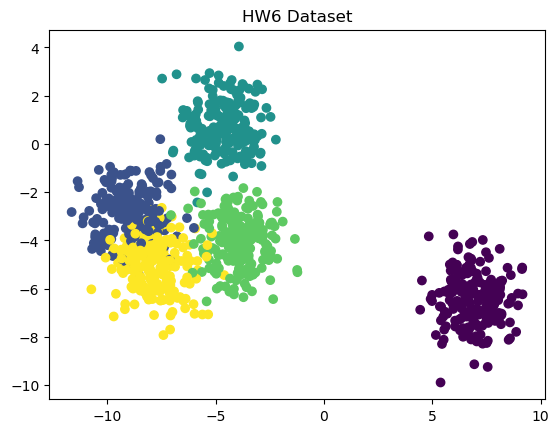

In [4]:
#setting variables
x = data[:,0]
y = data[:,1]
labels = data[:,2]

#making scatterplot
plt.scatter(x, y, c=labels) #c helps us set colors
plt.title('HW6 Dataset')

### Part 2

In [5]:
#Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth,
# testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel 
# density estimate of the distribution. 
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

#choosing 30 bandwidths between 0.1 and 1.0
bandwidths = np.linspace(0.1,1.0,30)

In [8]:
#concatenating x and y data
concat = np.concatenate([x,y])

In [26]:
#from lecture 14
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv=K) # Try each bandwidth with K-folds
grid.fit(data[:, :2]) #Fit the CONCATENATED DATA made in the previous cell
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.4724137931034482


0.4724137931034482


Text(0.5, 1.0, '2D KDE of Data')

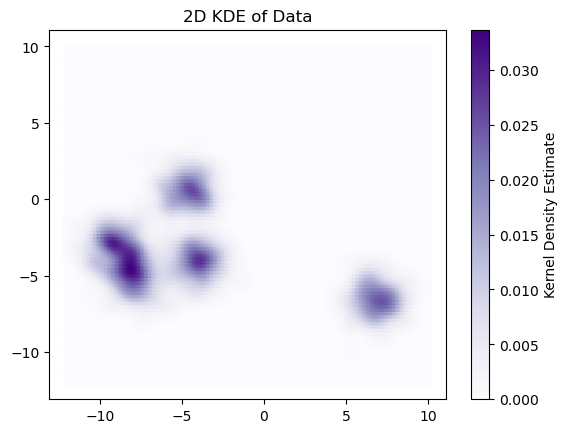

In [34]:
#Again from Lecture 14!

#2D Kernel Density
K = 5 # 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv=K) # Try each bandwidth with K-folds
grid.fit(data[:, :2]) #HERE I AM USING OUR 2D DATA SET AS THE DATA TO FIT TO
h_opt = grid.best_params_['bandwidth']
print(h_opt)
#back to regularly scheduled instantiation of KDE
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt) #using optimal bandwidth h_opt
kde.fit(data[:,:2]) #fit the model to the data

u = v = np.linspace(-12,10,100) #defining a linspace to plot over; this should extend across the full range of the data
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar(label='Kernel Density Estimate')
plt.title('2D KDE of Data')

### Part 3

In [32]:
#Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. 
#Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?
from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.neighbors import KernelDensity

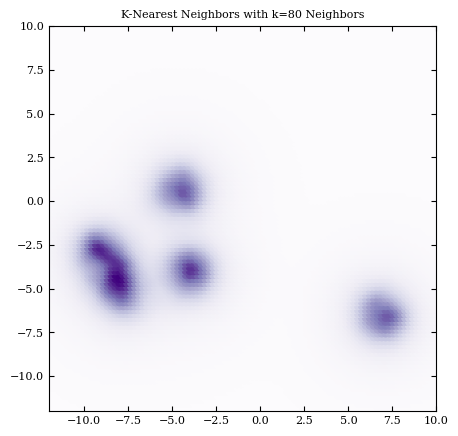

In [190]:
#FROM LECTURE 14:
 
#setting a guess for number of nearest neighbors
k = 80 #Number of neighbors

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data[:, :2])
dens_nbrs = nbrs.eval(Xgrid) #/ N

# plotting!
plt.figure(figsize=(5,5))
plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens_nbrs,
             cmap="Purples", edgecolor="None") #same colormap as above cells

# label the plot
plt.title('K-Nearest Neighbors with k=%i Neighbors' %k)

plt.show()

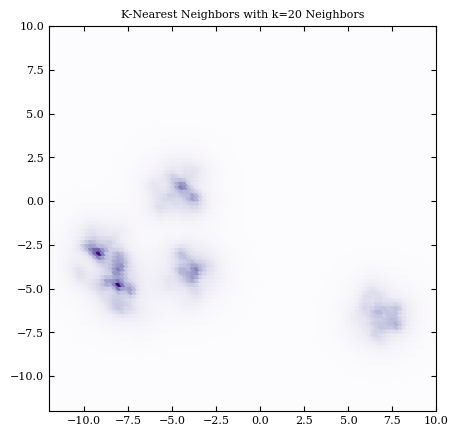

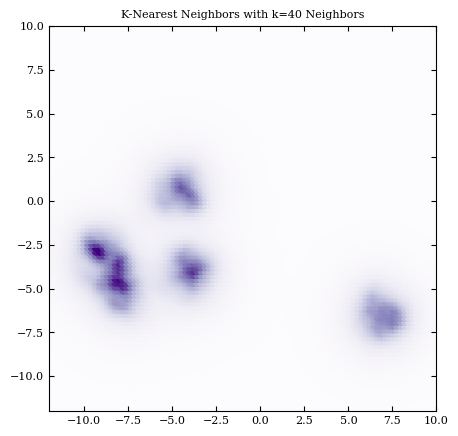

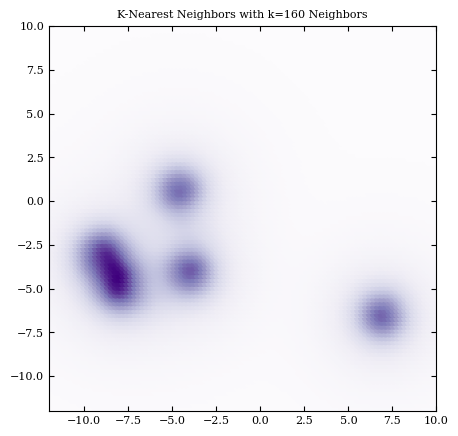

In [191]:
#Testing various numbers of neighbors to find a good choice
 
#20 NEIGHBORS
#setting a guess for number of nearest neighbors
k = 20 #Number of neighbors

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data[:, :2])
dens_nbrs = nbrs.eval(Xgrid) #/ N

# plotting!
plt.figure(figsize=(5,5))
plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens_nbrs,
             cmap="Purples", edgecolor="None") #same colormap as above cells

# label the plot
plt.title('K-Nearest Neighbors with k=%i Neighbors' %k)
plt.show()



#40 NEIGHBORS
#setting a guess for number of nearest neighbors
k = 40 #Number of neighbors

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data[:, :2])
dens_nbrs = nbrs.eval(Xgrid) #/ N

# plotting!
plt.figure(figsize=(5,5))
plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens_nbrs,
             cmap="Purples", edgecolor="None") #same colormap as above cells

# label the plot
plt.title('K-Nearest Neighbors with k=%i Neighbors' %k)
plt.show()



#200 NEIGHBORS
#setting a guess for number of nearest neighbors
k = 160 #Number of neighbors

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data[:, :2])
dens_nbrs = nbrs.eval(Xgrid) #/ N

# plotting!
plt.figure(figsize=(5,5))
plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens_nbrs,
             cmap="Purples", edgecolor="None") #same colormap as above cells

# label the plot
plt.title('K-Nearest Neighbors with k=%i Neighbors' %k)

plt.show()

<font color='lime'>  </font>

### Part 4

In [104]:
#Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. 
#Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? 
#Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, 
# and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

#importing tools
from sklearn.mixture import GaussianMixture

In [145]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

In [216]:
#FROM LECTURE 14

# Ivezic v2, Figure 4.2
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Set up the dataset.
#  We'll create our dataset by drawing samples from Gaussians.

random_state = np.random.RandomState(seed=1)

#X = np.concatenate([random_state.normal(-1, 1.5, 350),
#                    random_state.normal(0, 1, 500),
#                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1)

#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(data[:,:2])

# compute the AIC and the BIC
AIC = [m.aic(data[:,:2]) for m in models]
BIC = [m.bic(data[:,:2]) for m in models]

#bestfit mixture
M_best = models[np.argmin(AIC)]

x = np.linspace(-12, 10, 1000)
logprob = M_best.score_samples(Xgrid)#.reshape(-1, 1))
responsibilities = M_best.predict_proba(Xgrid)#x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

<font color='lime'>According to the BIC, 4 is the optimal number of components</font>

In [217]:
#fitting with 4 components
comps4 = GaussianMixture(4).fit(data[:,:2])

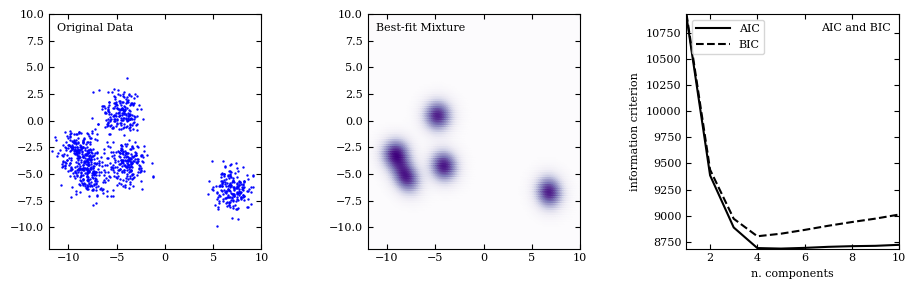

In [224]:
fig = plt.figure(figsize=(10, 3.4))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)

# plot 1: original data
ax = fig.add_subplot(131)
M_best = models[np.argmin(AIC)]

#ax.hist(data[:,:2], 30, density=True, histtype='stepfilled', alpha=0.4)
ax.scatter(data[:,0],data[:,1], s=0.5)
ax.set_xlim([-12,10])
ax.set_ylim([-12,10])
ax.text(0.04, 0.96, "Original Data",
        ha='left', va='top', transform=ax.transAxes)
#ax.plot(Xgrid, pdf, '-k')
#ax.plot(Xgrid, pdf_individual, '--k')

# plot 2: best-fit mixture
ax = fig.add_subplot(132)
ax.scatter(Xgrid[:,0], Xgrid[:,1], c=pdf, cmap="Purples", edgecolor="None")
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)


# plot 3: AIC and BIC
ax = fig.add_subplot(133)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.text(0.96, 0.96, "AIC and BIC",
        ha='right', va='top', transform=ax.transAxes)
ax.legend(loc=2)

In [235]:
#Fit the data with this optimal number of GMM components, and create a new plot that shows the data, the GMM component mean locations, and the $2$-sigma GMM component ellipses.

#getting means and covariances of best fit clusters
means  = M_best.means_
covars = M_best.covariances_

In [237]:
print(means.shape)
print(covars.shape)

(5, 2)
(5, 2, 2)


In [ ]:

#plotting
plt.figure(figsize=(6,6))
plt.scatter(data[:,0],data[:,1], s=0.5, c='b')
plt.scatter(means[:,0], means[:,1], c='r')

#plotting ellipses
draw_ellipse(mu=means,C=covars)

plt.show()
#plt.plot(comps4)

In [ ]:
# plot 3: posterior probabilities for each component
#ax = fig.add_subplot(133)

#p = responsibilities
#p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
#p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

## Part 5:

In [ ]:
#5. Now try Kmeans clustering with $5$ clusters. 
 #   - Use the `StandardScalar` to scale the data.
 #   - Fit the Kmeans model.
 #   - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
 #   - Predict the labels for the scaled data.
 #   - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.


